In [1]:
# Gun Detection Lab: Detecting Guns in Images using PyTorch and Faster R-CNN
# Use GPU: Runtime=>Change Runtime type=>T4 GPU

# Step 1: Install Dependencies
!pip install torch torchvision matplotlib opencv-python pycocotools py7zr requests

# Step 2: Import Libraries
import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import py7zr
import requests

# Step 3: Download and Extract Dataset
dataset_url = "https://github.com/frankwxu/AI4DigitalForensics/raw/main/lab02_Gun_detection_fasterRCNN/data/data.7z"
dataset_path = "/content/data.7z"
extracted_path = "/content/dataset"

# Download the dataset
!wget -O {dataset_path} {dataset_url}

# Extract the dataset
with py7zr.SevenZipFile(dataset_path, mode='r') as z:
    z.extractall(path=extracted_path)

# Define paths to images and labels
images_dir = os.path.join(extracted_path, "Images")
labels_dir = os.path.join(extracted_path, "Labels")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/

In [2]:
# Step 4: Create Custom Dataset Class
class GunDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.labels = list(sorted(os.listdir(os.path.join(root, "Labels"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        label_path = os.path.join(self.root, "Labels", self.labels[idx])

        img = Image.open(img_path).convert("RGB")
        target = self.parse_annotation(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def parse_annotation(self, label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            num_guns = int(lines[0].strip())  # Number of guns in the image
            bboxes = []
            labels = []

            # Parse each bounding box
            for i in range(1, num_guns + 1):
                bbox = list(map(int, lines[i].strip().split()))  # Bounding box (xmin, ymin, xmax, ymax)
                bboxes.append(bbox)
                labels.append(1)  # All objects are labeled as "Gun" (class 1)

        return {
            'boxes': torch.tensor(bboxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

In [3]:
# Step 5: Define Data Transforms
def get_transform(train):
    transforms = []
    transforms.append(torchvision.transforms.ToTensor())
    if train:
        transforms.append(torchvision.transforms.RandomHorizontalFlip(0.5))
    return torchvision.transforms.Compose(transforms)

# Step 6: Load Dataset
train_dataset = GunDataset(extracted_path, get_transform(train=True))
test_dataset = GunDataset(extracted_path, get_transform(train=False))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Step 7: Load Pre-trained Faster R-CNN Model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier head for custom classes
num_classes = 2  # Background + Gun
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 68.8MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [4]:
# Step 8: Define Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Step 9: Train the Model
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Iteration {i}, Loss: {losses.item()}")


In [5]:
# Train for 10 epochs
num_epochs = 1
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_one_epoch(model, optimizer, train_loader, device, epoch)


Epoch 1/1
Iteration 0, Loss: 0.7363923788070679
Iteration 10, Loss: 0.1587277054786682
Iteration 20, Loss: 0.16397720575332642
Iteration 30, Loss: 0.15436731278896332
Iteration 40, Loss: 0.18009600043296814
Iteration 50, Loss: 0.23029766976833344
Iteration 60, Loss: 0.20594128966331482
Iteration 70, Loss: 0.19515010714530945
Iteration 80, Loss: 0.19444917142391205
Iteration 90, Loss: 0.14671386778354645
Iteration 100, Loss: 0.2077881097793579
Iteration 110, Loss: 0.20448961853981018
Iteration 120, Loss: 0.29605674743652344
Iteration 130, Loss: 0.1862543523311615
Iteration 140, Loss: 0.2156934291124344
Iteration 150, Loss: 0.29083454608917236
Iteration 160, Loss: 0.23125450313091278


In [6]:
# Step 10: Save the Trained Model
model_save_path = "/content/gun_detection_model_30epoch.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/gun_detection_model_30epoch.pth


In [7]:
# Step 11: Evaluate the Model
def evaluate_model(model, data_loader, device, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for output, target in zip(outputs, targets):
                # Ground truth labels and boxes
                gt_boxes = target['boxes'].cpu().numpy()
                gt_labels = target['labels'].cpu().numpy()

                # Predicted labels, boxes, and scores
                pred_boxes = output['boxes'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()

                # Filter predictions by confidence threshold
                valid_preds = pred_scores > score_threshold
                pred_boxes = pred_boxes[valid_preds]
                pred_labels = pred_labels[valid_preds]

                # Match predictions to ground truth using IoU
                matched_gt_indices = set()  # To track matched ground truth boxes
                for pred_box, pred_label in zip(pred_boxes, pred_labels):
                    best_iou = 0
                    best_gt_idx = -1

                    # Compute IoU between the predicted box and all ground truth boxes
                    for gt_idx, gt_box in enumerate(gt_boxes):
                        iou = compute_iou(pred_box, gt_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx

                    # If the best IoU exceeds the threshold, consider it a match
                    if best_iou >= iou_threshold and best_gt_idx not in matched_gt_indices:
                        all_preds.append(pred_label)  # Predicted label
                        all_labels.append(gt_labels[best_gt_idx])  # Ground truth label
                        matched_gt_indices.add(best_gt_idx)
                    else:
                        # Unmatched prediction (treated as Background)
                        all_preds.append(0)  # Background label
                        all_labels.append(0)  # Background label

                # Add unmatched ground truth boxes as false negatives
                for gt_idx, gt_label in enumerate(gt_labels):
                    if gt_idx not in matched_gt_indices:
                        all_preds.append(0)  # Background label
                        all_labels.append(gt_label)  # Ground truth label

    print("\nClassification Report:")
    from sklearn.metrics import classification_report
    print(classification_report(all_labels, all_preds, target_names=['Background', 'Gun']))

# Helper function to compute IoU
def compute_iou(box1, box2):
    """
    Compute Intersection over Union (IoU) between two bounding boxes.
    Each box is represented as [xmin, ymin, xmax, ymax].
    """
    # Compute coordinates of intersection rectangle
    xmin = max(box1[0], box2[0])
    ymin = max(box1[1], box2[1])
    xmax = min(box1[2], box2[2])
    ymax = min(box1[3], box2[3])

    # Compute area of intersection
    inter_width = max(0, xmax - xmin)
    inter_height = max(0, ymax - ymin)
    inter_area = inter_width * inter_height

    # Compute area of both boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute IoU
    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

evaluate_model(model, test_loader, device)


Classification Report:
              precision    recall  f1-score   support

  Background       0.60      1.00      0.75       142
         Gun       1.00      0.78      0.88       428

    accuracy                           0.83       570
   macro avg       0.80      0.89      0.81       570
weighted avg       0.90      0.83      0.84       570



In [8]:
# Step 12: Download Pre-trained Model from Dropbox with high accuracy I trained with 1 hour
dropbox_model_url = "https://www.dropbox.com/scl/fi/prwobzaj9i7ks1qirvs4u/gun_detection_model_30epoch.pth?rlkey=bdqqc7m6hxnzaapxo5hm8z1pm&st=m0cpspeb&dl=1"
local_model_path = "/content/gun_detection_model_30epoch.pth"

if not os.path.exists(local_model_path):
    print("Downloading pre-trained model from Dropbox...")
    response = requests.get(dropbox_model_url, stream=True)
    with open(local_model_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print(f"Model downloaded to {local_model_path}")
else:
    print(f"Pre-trained model already exists at {local_model_path}")

Pre-trained model already exists at /content/gun_detection_model_30epoch.pth


<ipython-input-11-395a432a9502>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


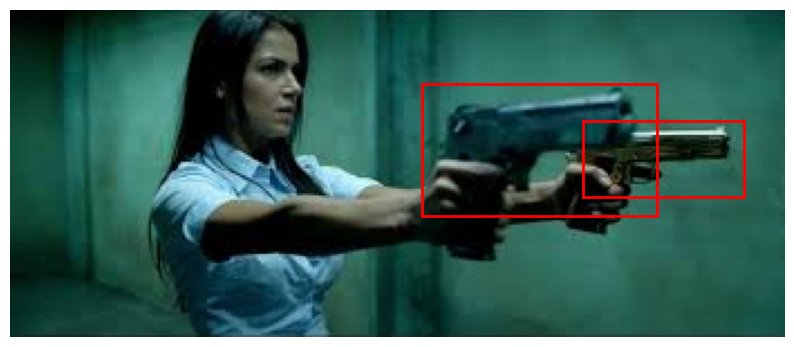

In [11]:
# Step 13: Load Pre-trained Model
def load_model(model_path):
    # Load the pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    num_classes = 2  # Background + Gun
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load the saved state dictionary
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Step 14: Test on Custom Images Using Saved Model
def predict_image(img_path, model, transform):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        prediction = model(img_tensor)[0]

    # Plot the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        if label == 1 and score > 0.5:  # Gun detected with confidence > 0.5
            box = box.cpu().numpy()
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                              edgecolor='red', facecolor='none', linewidth=2))
    plt.axis('off')
    plt.show()

# Example Usage for Testing
custom_image_path = '/content/dataset/Images/3.jpeg'  # Update this path

# Load the pre-trained model
model = load_model(local_model_path)

# Predict on a custom image
predict_image(custom_image_path, model, get_transform(train=False))